In [1]:
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


# Data preprocessing and parameters

In [5]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size

x_train = x_train.astype('float32') / 255. # Nawid - Divides the values by 255
x_test = x_test.astype('float32') / 255.
x_train =np.reshape(x_train, [-1, image_size, image_size, 1])
x_test =np.reshape(x_test, [-1, image_size, image_size, 1])


# Nawid - Noisy version of the testing and training data for denoising purposes
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# network parameters
input_shape = (28,28,1)
intermediate_dim = 512
batch_size = 128
latent_dim = 32
epochs = 5
conv_filters = 16
conv_kernel_size = 3

# Encoder architecture

In [15]:
# Nawid - Layers for the encoder architecture
x = tf.keras.layers.Input(shape=(image_size,image_size,1))  # Nawid - Input layer
x1 = tf.keras.layers.Conv2D(filters = conv_filters, kernel_size = conv_kernel_size, activation ='relu', strides = 2, padding = 'same')(x)
x2 = tf.keras.layers.Conv2D(filters = 2*conv_filters, kernel_size = conv_kernel_size, activation ='relu', strides = 2, padding = 'same')(x1)

shape = tf.keras.backend.int_shape(x2) # Nawid - THIS OBTAINS THE SHAPE NEEDED TO BE SPECIFIED FOR THE DECONVOLUTION (CONVTRANPOSE IN THE DECODER) 
flattened_x = tf.keras.layers.Flatten()(x2)
# Nawid - This is an additional layer to obtain an intermediate representation beforehand - need to change to h
h = tf.keras.layers.Dense(intermediate_dim, activation='relu')(flattened_x)
z_mean = tf.keras.layers.Dense(latent_dim)(h)  #
z_log_sigma = tf.keras.layers.Dense(latent_dim)(h)



In [16]:
class Sampling(tf.keras.layers.Layer): # Nawid - Specifies a custom layer
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_sigma = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # Nawid - Initalised random values with a mean of 0 and a standard deviation of 1
    return z_mean + tf.exp(0.5 * z_log_sigma) * epsilon

z = Sampling()((z_mean, z_log_sigma)) # Nawid - Instantiates the custom layer and gets the output of the custom layer which is the value of z


# Decoder architecture

In [17]:
# Nawid - Specifies the decoder layers
z_decoded = tf.keras.layers.Dense(intermediate_dim, activation ='relu')(z)
z_decoded = tf.keras.layers.Dense(shape[1]*shape[2]*shape[3], activation='relu')(z_decoded) # Nawid - z_decoded
z_decoded = tf.keras.layers.Reshape((shape[1], shape[2], shape[3]))(z_decoded)

z_decoded = tf.keras.layers.Conv2DTranspose(filters =conv_filters, kernel_size = conv_kernel_size, activation ='relu', strides=2, padding='same')(z_decoded)
z_decoded = tf.keras.layers.Conv2DTranspose(filters =conv_filters//2, kernel_size = conv_kernel_size, activation ='relu', strides=2, padding='same')(z_decoded)
x_decoded = tf.keras.layers.Conv2DTranspose(filters =1, kernel_size = conv_kernel_size, activation ='sigmoid',padding = 'same')(z_decoded)


# VAE instantiation

In [18]:
# end-to-end autoencoder
vae = tf.keras.Model(x, x_decoded)
vae.summary()

# Nawid - Specifies the encoder model
encoder = tf.keras.Model(x, z)
encoder.summary()


# Nawid - Copies the layers of autoencoder layers corresponding to the decoder layers
decoder_layer1 = vae.layers[-6]
decoder_layer2 = vae.layers[-5]
decoder_layer3 = vae.layers[-4]
decoder_layer4 = vae.layers[-3]
decoder_layer5 = vae.layers[-2]
decoder_layer6 = vae.layers[-1]
# Nawid - Specifies the input of the decoder
decoder_input = tf.keras.layers.Input(shape = (latent_dim))

# Nawid - Decoded outputs
decoded_z = decoder_layer1(decoder_input)
decoded_z = decoder_layer2(decoded_z)
decoded_z = decoder_layer3(decoded_z)
decoded_z = decoder_layer4(decoded_z)
decoded_z = decoder_layer5(decoded_z)
reconstructed_x = decoder_layer6(decoded_z)

decoder = tf.keras.Model(decoder_input, reconstructed_x)
decoder.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 16)   160         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 32)     4640        conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 1568)         0           conv2d_3[0][0]                   
____________________________________________________________________________________________

In [19]:
def vae_loss(x, x_decoded_mean):
    xent_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(x), tf.keras.backend.flatten(x_decoded_mean))
    xent_loss *= original_dim
    #xent_loss = tf.keras.backend.mean(xent_loss)
    kl_loss = - 0.5 * tf.keras.backend.mean(1 + z_log_sigma - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss,experimental_run_tf_function=False) 
# Explanation for where experimental_run_tf comes from -  https://github.com/tensorflow/probability/issues/519 

#vae.compile(optimizer='adam', loss='binary_crossentropy', experimental_run_tf_function=False)

In [20]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 17s 283us/sample - loss: 161.3247 - val_loss: 92.5967
Epoch 2/5
60000/60000 [==============================] - 16s 264us/sample - loss: 81.2018 - val_loss: 73.1573
Epoch 3/5
60000/60000 [==============================] - 16s 261us/sample - loss: 71.3220 - val_loss: 68.2984
Epoch 4/5
60000/60000 [==============================] - 16s 272us/sample - loss: 67.5738 - val_loss: 65.8351
Epoch 5/5
60000/60000 [==============================] - 16s 274us/sample - loss: 65.5470 - val_loss: 64.4564


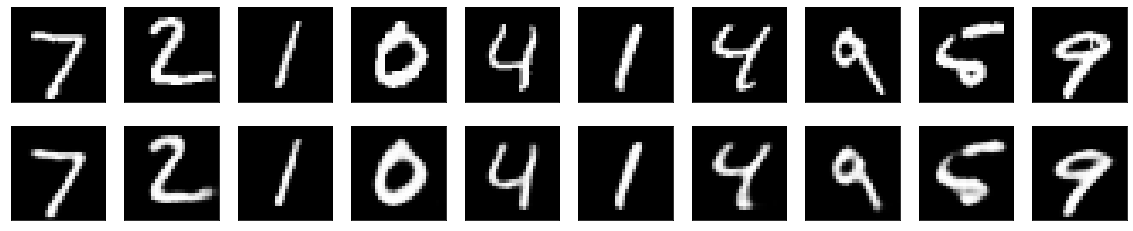

In [23]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
#decoded_imgs = vae.predict(x_test)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()